# 1D scalar wave equation PML profiles
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](www.ausargeo.com))*

When numerically simulating wave propagation, such as for seismic imaging/inversion, we often run the simulation on a limited area. To avoid reflections from the boundaries of this limited area, we need to absorb waves reaching the boundaries. For 2D and 3D finite difference wave propagation, I think the most popular way by far to do this these days is with a technique known as a perfectly matched layer (PML). Steven G. Johnson has a [very clear introduction](http://math.mit.edu/~stevenj/18.369/pml.pdf) to the topic. One parameter of the method is the  size of the PML. Like many things, bigger is better here, as a thicker PML enables better absorption. Once the thickness is decided, the only other parameter is the shape of the sigma function (See SGJ's introduction for an explanation of what sigma is), which I refer to as the "profile". I don't think it is obvious what the best shape for this profile is in theory (if you know of such work, please let me know!), so in this notebook I experiment with a few different profiles to see what works best. To keep the computational cost down, I only work in 1D. It's possible that the profiles behave differently in other dimensions, but that is a job for another notebook.

To facilitate this exploration, I wrote a little bit of code, which I import below. It primarily consists of a Fortran code to do the wave propagation and apply the PML, and Python code to create synthetic models and run an optimizer to find good profiles.

The [Fortran code](https://github.com/ar4/wave_1d_fd_pml/blob/master/wave_1d_fd_pml/pml.f90) contains my derivation of the PML code for the 1D scalar wave equation (in the comment at the beginning of the `fd_pml1` subroutine). This differs slightly from [the PML implementation](https://github.com/pysit/pysit/blob/master/pysit/solvers/constant_density_acoustic/time/scalar/constant_density_acoustic_time_scalar_1D_4.h) I found in [PySIT](www.pysit.org). I'm not sure where the PySIT version comes from, but it has some advantages over my own. The largest of these is that outside of the PML region you can just use the regular scalar wave equation, whereas with my implementation you need to use a modified propagator everywhere. I thus compare both implementations below. My own is referred to as version 1, and the PySIT one is version 2.

In [3]:
from wave_1d_fd_pml import propagators, test_wave_1d_fd_pml, find_profile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)

ImportError: No module named 'hygsa'

I am going to use a profile length of 10 cells. This means that on both ends of my 1D domain, I add 10 cells where sigma will be non-zero, causing any incoming waves to be attenuated (hopefully so much that they disappear). The values of sigma in these 10 cells, the "profile", are what I am trying to optimize below.

Just to make completely sure that we are all on the same page, here's a plot of sigma over the whole domain:

In [ ]:
v = propagators.Pml1(np.zeros(100), 5)
plt.plot(v.sigma)
plt.xlabel('x')
plt.ylabel('sigma')

Sigma is zero in the interior of the domain - the place where we want to propagate the waves normally. The shape it has at the edges of the domain, where it causes waves to be attenuated, is what we are going to explore. Our sigma will be the same on both sides of the domain, so we will just talk about the shape on the right side from now on, but it will always be mirrored on the left side.

10 was a fairly arbitrary choice (it's one quarter of the wavelength of a 25 Hz wave in a 5000 m/s medium, when the cell size is 5 m). For longer wavelengths or smaller cell sizes, you may need to increase it.

I also choose the `maxiter` value to be 500 in the next cell. This controls the number of iterations that the optimizers run for below.

The `vs` variables contains the array of velocities that will be used when evaluating the PML effectiveness. More velocities makes the process slower.

In [3]:
profile_len = 10
maxiter = 500
vs = np.linspace(1500, 5000, 3)

## Profile optimization

To explore the kinds of profiles that work well, I am going to try different ones and test how effective they are. My measure of effectiveness will be the sum of absolute values of the wavefield after 500 timesteps in a simple model that consists of one 25 Hz Ricker wavelet source, and one reflector. To improve the generality of the results, I run the wave propagation multiple times with different wave speeds on either side of the reflector, so the results are not tuned for specific wave speeds.

I use the [HyGSA](https://github.com/sgubianpm/pygensa) optimizer to find good parameters for the profiles. This is a type of simulated annealing algorithm, and apparently works well in many cases. I do not know that the cost function (the sum of the absolute wavefield values, as mentioned above) is convex, so I need to use a global optimizer like this. Some of the profile models I explore have quite a few parameters, so a brute force parameter search would be too expensive.

### Linear profile

A linear profile is often used for PMLs. It corresponds to `sigma[i] = x[0] + x[1] * i`, where `i` is the distance into the PML.

In [3]:
x_linear1, profile_linear1 = find_profile.find_profile_linear(profile_len, maxiter=maxiter, pml_version=1)
x_linear2, profile_linear2 = find_profile.find_profile_linear(profile_len, maxiter=maxiter, pml_version=2)

global minimum: xmin = [  54.08727823  114.08869748], f(xmin) = 3.8412904739379883
global minimum: xmin = [  79.98107551  258.96492748], f(xmin) = 3.049506902694702


The results for the two PML implementations (the first is my own, the second is the one from PySIT) are shown above. It first gives us the values of `x[0]` and `x[1]` that resulted in the most effective PML (smallest cost function, which is the sum of absolute values of the wavefield at the final time step, indicating that the waves had been strongly attenuated when they reached the edges of the domain). The value of the cost function for these parameter values is also given as `f(xmin)`.

We see that in both my implementation and the one I got from PySIT, the PML works best when the intercept of the linear profile is nonzero (around 60). Interestingly, this is quite a bit smaller than the optimal slope values found, which are around 100 and 250 for the two implementations. This means that for the first cell in the PML region we take a little jump in sigma, but then a bigger jump for the rest of the cells. Does this perhaps suggest that a profile that allows curvature might do better? Maybe we need to increase the rate at which sigma is increasing as we go deeper into the PML. We'll try that next.

The other thing to note is that PySIT's PML implementation did better here - the cost function of the best parameters was smaller (3.0) than for my own implementation (3.8), indicating that it attenuated the waves more effectively.


### Powers of linear functions

Since the previous result suggested that some curvature might be beneficial, I will next try giving the optimizer an additional parameter to explore by raising the linear function to a power. This corresponds to `sigma[i] = (x[0] + x[1] * i) ^ x[2]`.

In [4]:
x_power1, profile_power1 = find_profile.find_profile_power(profile_len, maxiter=maxiter, pml_version=1)
x_power2, profile_power2 = find_profile.find_profile_power(profile_len, maxiter=maxiter, pml_version=2)

global minimum: xmin = [  78.95749779  167.99706609    1.01597855], f(xmin) = 3.7984459400177
global minimum: xmin = [  80.56728417  260.0199796     1.00000475], f(xmin) = 3.0488014221191406


Interestingly, the optimizer did not find this additional flexibility useful: the values it found for `x[2]`, the power, are about 1 for both implementations, so the profile is pretty-much the same as the linear one in the previous experiment. Unsurprisingly, the minimum cost function values have not changed substantially.

Perhaps this means that linear profiles really are best for PMLs? Let's have another go with a different type of curvature.


### Cosine

This time I'm going to try `sigma[:] = x[0] + x[1] * cos(linspace(x[2], x[2] + x[3], profile_len))`. That's quite a bit of flexibility. The optimizer gets to choose a constant bias (`x[0]`), a scaling factor of the cosine (`x[1]`), and the range of the 10 values that the cosine is applied to (linearly spaced between `x[2]` and `x[2] + x[3]`). Let's see what it comes up with.

In [5]:
x_cosine1, profile_cosine1 = find_profile.find_profile_cosine(profile_len, maxiter=maxiter, pml_version=1)
x_cosine2, profile_cosine2 = find_profile.find_profile_cosine(profile_len, maxiter=maxiter, pml_version=2)

global minimum: xmin = [  9.87384719e+02  -1.01532757e+03   3.40057787e-01   1.56992421e+00], f(xmin) = 4.631070613861084
global minimum: xmin = [  2.46076834e+03  -2.74333428e+03   5.10776743e-01   1.42149908e+00], f(xmin) = 3.2058234214782715


With the amount of iterations I allowed, the optimizer did not find better profiles than it did with the previous models: the cost function values of the best parameters have increased for both PML implementations. The profiles do have some curvature this time (`x[3]` is not zero), but it seems that it didn't help. It is possible, though, that the results might have been better with more optimizer iterations.


### Free-form

Finally, I'll give the optimizer free rein to choose whatever profile it wants. This time, the value of sigma at each cell in the profile is a parameter, so `sigma[i] = x[i]`. Such an unconstrained model will be very challenging for the optimizer, but let's see what happens anyway.

In [4]:
x_freeform1, profile_freeform1 = find_profile.find_profile_freeform(profile_len, maxiter=maxiter, pml_version=1)
x_freeform2, profile_freeform2 = find_profile.find_profile_freeform(profile_len, maxiter=maxiter, pml_version=2)

global minimum: xmin = [   78.48412131   236.07687442   331.98741718   372.65346271   546.59970739
   879.2970951   1273.69911473   914.39634224  1059.26144799  1763.52502149], f(xmin) = 4.290159702301025
global minimum: xmin = [  112.5813677    453.92688036  1179.87282568   584.90478608    63.61415713
  3319.21461045  2688.4130666    158.92330667  3366.06172336    69.07225296], f(xmin) = 2.739487409591675


Interestingly...


## Results

Linear models are not only easy to optimize, but they also seem to perform pretty well as PML profiles.

pml version 1
5.68273
434.31
5.15547
1.01481e+10
pml version 2
3.67726
3.66916
nan
nan


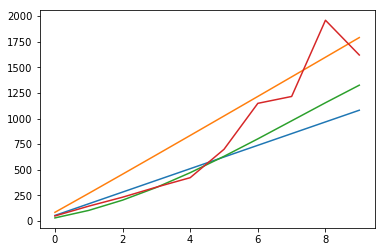

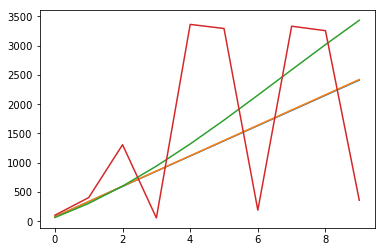

In [10]:
model = test_wave_1d_fd_pml.model_one(500, v0=5000, v1=1500, freq=25)
profiles=[[profile_linear1, profile_power1, profile_cosine1, profile_freeform1],
         [profile_linear2, profile_power2, profile_cosine2, profile_freeform2]]
for pml_version, profiles in enumerate(profiles):
    plt.figure()
    print('pml version', pml_version+1)
    if pml_version == 0:
        prop = propagators.Pml1
    else:
        prop = propagators.Pml2
    for profile in profiles:
        plt.plot(profile)
        v = prop(model['model'], model['dx'], model['dt'], len(profile), profile=profile)
        y = v.steps(model['nsteps'], model['sources'], model['sx'])
        print(np.sum(np.abs(v.current_wavefield)))




In [1]:
profile = profile_linear2
prop = propagators.Pml2
v = prop(model['model'], model['dx'], model['dt'], len(profile), profile=profile)
y = v.steps(model['nsteps'], model['sources'], model['sx'])
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[8:-8], aspect='auto')

NameError: name 'profile_linear2' is not defined